In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from numpy import inf
from matplotlib import rc
rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [3]:
def getJetData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')

    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')

    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
def getLeptonData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [6]:
##Selection on event variables
def applyEventCuts(df):
    print '################### ' 
    print 'Applying event selection'
    temp = df 
    #temp = applyCut(temp, 'y < 0.95 and y>0.01', '0.01 < y < 0.95')
    temp = applyCut(temp, 'y < 0.85 and y>0.1', '0.1 < y < 0.85')

    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    print '################### \n' 
    return temp


## Selection on event and jet variables
def applyJetCuts(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    temp = applyCut(temp, 'jet_pt>5', 'jet_pt>5')
    temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    temp.eval('dphi = 3.14159-dphi_e_jet', inplace=True)
    temp.eval('jet_qtnorm= jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/sqrt(jet_pt)', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/sqrt(e_pt)', inplace=True)

    temp = applyCut(temp, 'jet_qtnormjetpt<.30', 'qt/ptjet<.30')

    #temp = applyCut(temp, 'jet_qtnormjetpt<0.3', 'qt/ptjet<0.3')

    df = applyCut(df, 'n_total>1', ' n>1')
    return temp

In [7]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

## Get data

In [10]:
#df_inclusive = getLeptonData(['NC_10_275.root'])
df_inclusive = getLeptonData(['pytree.root'])

xsec = np.mean(df_inclusive['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df_inclusive.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)
lumi = 100 # in units of fb-1. 
to_counts = to_cross_section*1000*lumi #1000 accounts to pass from pb to fb
##Apply selection
df_inclusive = applyEventCuts(df_inclusive)



Processed pytree.root in 1.2 seconds
xsection 17676.24 [pb]
accepted events 999997
################### 
Applying event selection
0.1 < y < 0.85 535174  fraction kept: 53.5
Q2>25 531834  fraction kept: 99.4
################### 



In [9]:
##Total cross-section: 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)

Integrated rate 1764.920 [M]


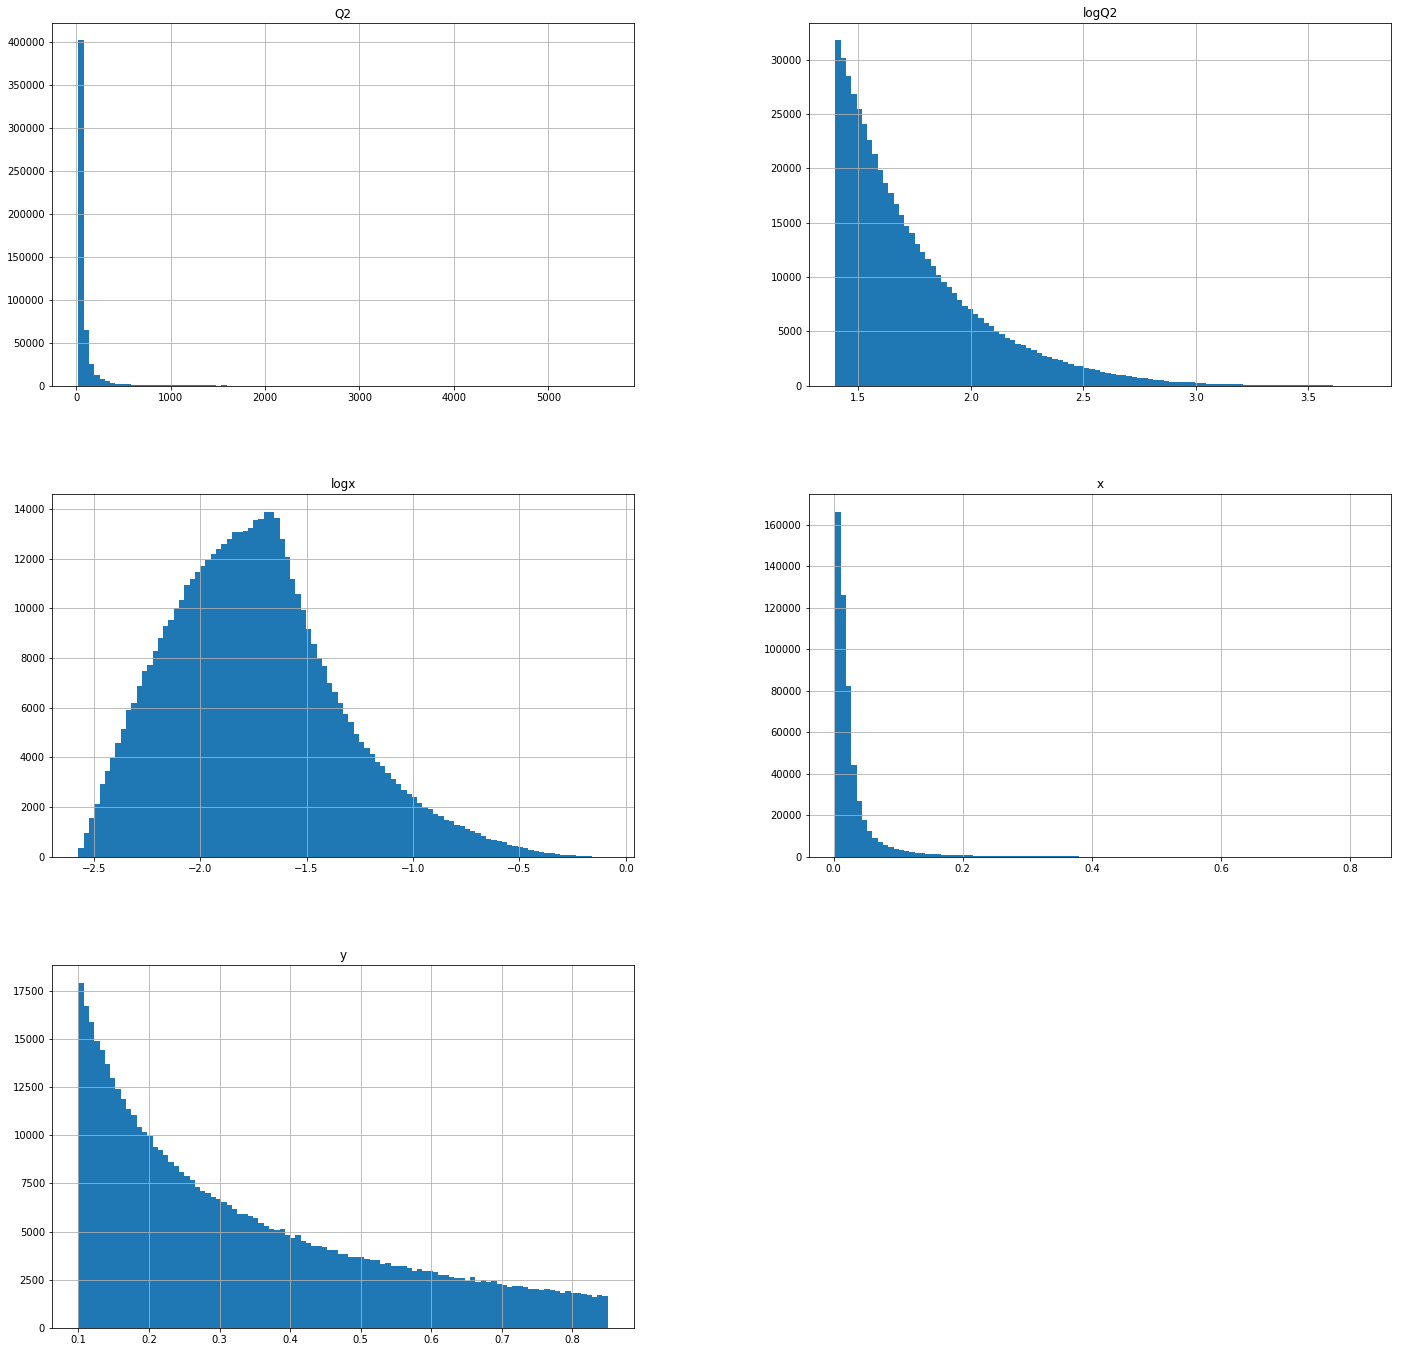

In [11]:
rc('text', usetex=False)
df_inclusive.hist(figsize=(24,24),bins=100,column=['x','Q2','logx','logQ2','y'])
plt.show()

## get jet data

In [12]:
#df_jet      = getJetData(['NC_10_275.root'])
df_jet      = getJetData(['pytree.root'])
df_jet = applyEventCuts(df_jet)
df_jet = applyJetCuts(df_jet)


Processed pytree.root in 25.2 seconds
################### 
Applying event selection
0.1 < y < 0.85 283821  fraction kept: 49.9
Q2>25 283531  fraction kept: 99.9
################### 

0.1 < y < 0.85 283531  fraction kept: 100.0
Q2>25 283531  fraction kept: 100.0
jet_pt>5 283531  fraction kept: 100.0
dphi_e_jet>3.14159-0.4 260464  fraction kept: 91.9
qt/ptjet<.30 66359  fraction kept: 25.5
 n>1 282232  fraction kept: 99.5


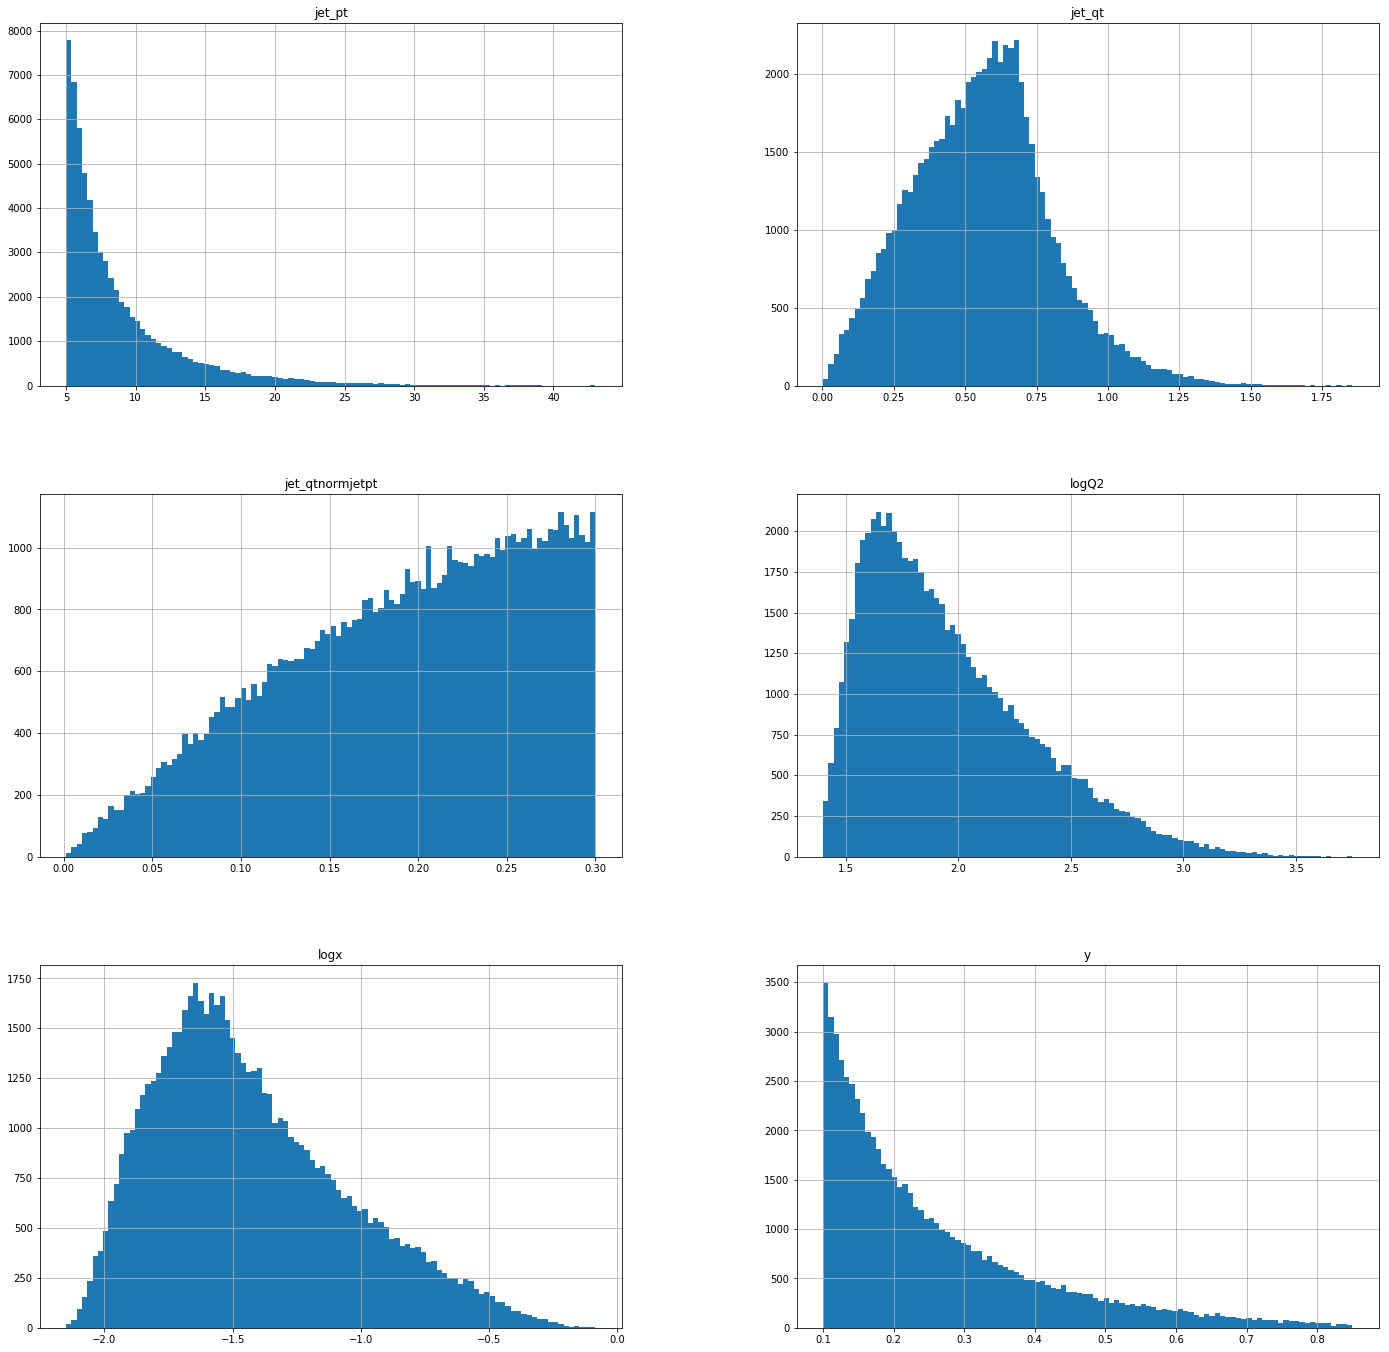

In [13]:
rc('text', usetex=False)
df_jet.hist(figsize=(24,24),bins=100,column=['jet_qt','jet_pt','jet_qtnormjetpt','logx','logQ2','y'])
plt.show()

Cross section [3.20583898e+07 1.90809759e+07 1.14788528e+07 6.98841793e+06
 4.15925360e+06 2.43596945e+06 1.26915118e+06 6.31423163e+05
 2.41826670e+05 6.55355193e+04 8.32644021e+03]


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


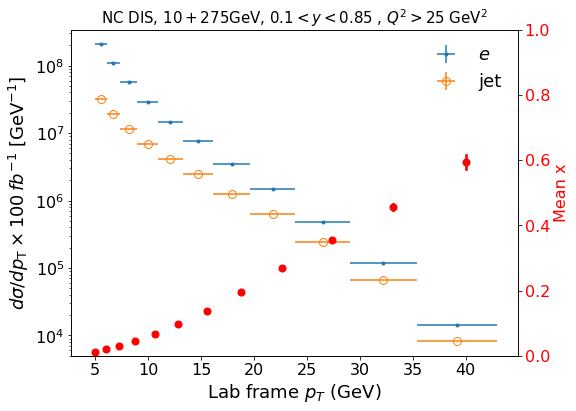

In [14]:
import seaborn as sns
nbins = 12
minpt = 5
maxpt = df_jet['jet_pt'].max()
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
y, x  = np.histogram(df_inclusive.query('e_pt>5')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts
yerr = np.sqrt(y)

y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)

plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$e$')


y, x  = np.histogram(df_jet.query('dphi<0.4 and jet_pt>5')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='jet')


plt.yscale('log')
ax1.set_xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
plt.title(r'NC DIS, $10+275 \mathrm{GeV}$, $0.1 < y < 0.85$ , $Q^2 > 25\ \mathrm{GeV^2}$',   fontsize=15)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

###Mean x vs pT
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='red')
sns.regplot(df_inclusive['e_pt'], df_inclusive['x'], x_bins=np.logspace(np.log10(minpt),np.log10(40),nbins),fit_reg=None,color='red')
ax2.set_ylabel('Mean x' ,color='red',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax2.set_ylim([0.0,1.0])

#ax2.scale('log')
plt.savefig('CrossSection_NC.png', bbox_inches='tight')
plt.savefig('CrossSection_NC.pdf', bbox_inches='tight')

plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

## Factors for statistical projection

In [15]:
dilution_factor =0.7 # proton polarization for single-spin asymmetries ()
efficiency = 0.5 #efficiency
penalty = np.sqrt(2)# coming from separating Sivers v Collins v something else
lumi = 100 # in units of fb-1. 100 is expected in a year? (check)

#label = " 10+100 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$"
label = " 10+275 GeV, 100 fb$^{-1}$, $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$"

## Sivers asymmetry (phi) for various electron pT

6.872142  mean lepton pt
0.25568706  mean inelasticity
0.0  mean jet p
6.8514075  mean jet pT
count    19882.000000
mean         6.851408
std          0.690748
min          5.335077
25%          6.330795
50%          6.799455
75%          7.341437
max          8.805688
Name: jet_pt, dtype: float64
0.02847014  mean x
68.504906  mean Q2
count    19882.000000
mean        68.504906
std         28.109636
min         40.100010
25%         52.034739
50%         62.044559
75%         74.442146
max        401.614227
Name: Q2, dtype: float64
 
9.906491  mean lepton pt
0.25465974  mean inelasticity
0.0  mean jet p
9.861994  mean jet pT
count    7727.000000
mean        9.861994
std         0.717390
min         8.185424
25%         9.315280
50%         9.840694
75%        10.363337
max        11.943163
Name: jet_pt, dtype: float64
0.059432704  mean x
142.14615  mean Q2
count    7727.000000
mean      142.146149
std        57.639091
min        90.496727
25%       111.342926
50%       127.801109
75%  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in divide


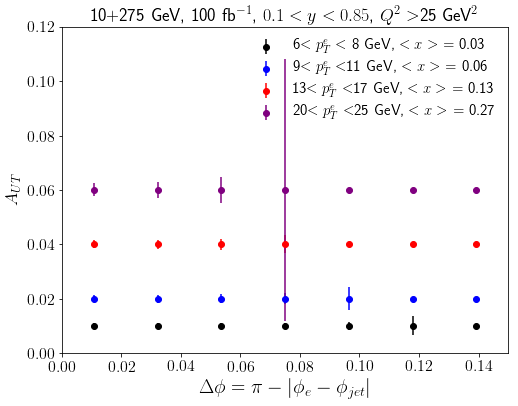

In [16]:
rc('text', usetex=True)

def fake_A(x,slope=0.05):
    return slope*np.ones(len(x))

fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.06]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0),(20,25)]):
    maxdphi = 0.15
    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    mean_x = df_cut['x'].mean()
    printSummary(df_cut)

    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none', color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f GeV, $<x>$ = %2.2f'%(edges[0],edges[1],mean_x))
    print ' '
####
plt.legend(frameon=False,loc='best',ncol=2,fontsize=16)
plt.ylim([0.0,0.12])
#plt.ylim([-0.15,0.15])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlim([0.0,0.15])

plt.title(label, fontsize=18)
plt.legend(loc='best', fontsize=15,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers.png', bbox_inches='tight')
plt.savefig('AUT_Sivers.pdf', bbox_inches='tight')

## Sivers vs x 

10.659067  mean lepton pt
0.22299673  mean inelasticity
0.0  mean jet p
10.602212  mean jet pT
count    11585.000000
mean        10.602212
std          2.027995
min          6.489436
25%          9.047659
50%         10.343960
75%         11.965275
max         17.411253
Name: jet_pt, dtype: float64
0.06987301  mean x
170.92549  mean Q2
count    11585.000000
mean       170.925491
std        114.401466
min         55.356293
25%         95.522118
50%        130.969086
75%        204.353851
max        921.529114
Name: Q2, dtype: float64
 
16.706192  mean lepton pt
0.21995263  mean inelasticity
0.0  mean jet p
16.587376  mean jet pT
count    2265.000000
mean       16.587376
std         2.823350
min        11.466140
25%        14.202346
50%        16.003605
75%        18.858906
max        24.360128
Name: jet_pt, dtype: float64
0.17236048  mean x
416.65405  mean Q2
count    2265.000000
mean      416.654053
std       271.766235
min       166.393509
25%       234.115952
50%       310.983429
75%

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


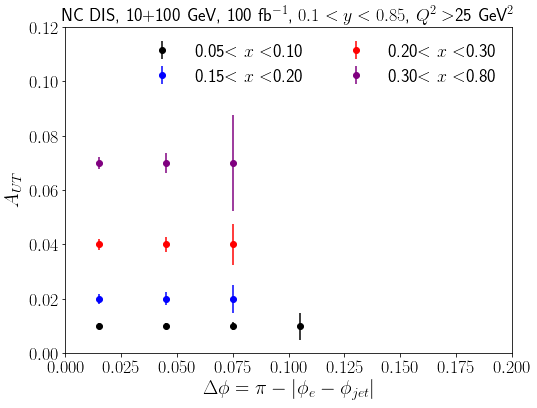

In [17]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.07]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(0.05,0.1), (0.15,0.2),(0.2,0.3),(0.3,0.8)]):
    maxdphi = 0.6
    nbins  = 20
    df_cut = df_jet.query('x > %2.2f and x<%2.2f'%(edges[0],edges[1]))
    printSummary(df_cut)

    y, x  = np.histogram(df_cut['dphi'],bins=nbins,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency # take efficiency hit
    y[y<100] = 0

    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    x[erry == inf] = 1000

    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter],label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
    print ' '
####
plt.ylim([0.0,0.12])
plt.xlim([0.0,0.2])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('NC DIS, 10+100 GeV, 100 fb$^{-1}$, $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=18,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=20)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_xbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xbins.pdf', bbox_inches='tight')

## Sivers vs qT/ptjet

10.659067  mean lepton pt
0.22299673  mean inelasticity
0.0  mean jet p
10.602212  mean jet pT
count    11585.000000
mean        10.602212
std          2.027995
min          6.489436
25%          9.047659
50%         10.343960
75%         11.965275
max         17.411253
Name: jet_pt, dtype: float64
0.06987301  mean x
170.92549  mean Q2
count    11585.000000
mean       170.925491
std        114.401466
min         55.356293
25%         95.522118
50%        130.969086
75%        204.353851
max        921.529114
Name: Q2, dtype: float64
 
16.706192  mean lepton pt
0.21995263  mean inelasticity
0.0  mean jet p
16.587376  mean jet pT
count    2265.000000
mean       16.587376
std         2.823350
min        11.466140
25%        14.202346
50%        16.003605
75%        18.858906
max        24.360128
Name: jet_pt, dtype: float64
0.17236048  mean x
416.65405  mean Q2
count    2265.000000
mean      416.654053
std       271.766235
min       166.393509
25%       234.115952
50%       310.983429
75%

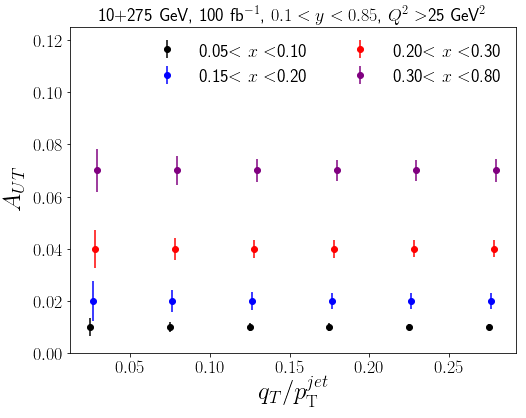

In [18]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.07]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(0.05,0.1), (0.15,0.2),(0.2,0.3),(0.3,0.8)]):
    maxvalue = 0.3
    offset = 0.0015*counter
    nbins  = 6
    df_cut = df_jet.query('x > %2.2f and x<%2.2f'%(edges[0],edges[1]))
    printSummary(df_cut)

    y, x  = np.histogram(df_cut['jet_qtnormjetpt'],bins=nbins,range=(0.0,maxvalue))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency # take efficiency hit
    y[y<100] = 0

    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    x[erry == inf] = 1000

    x +=offset
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter],label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
    print ' '
####
plt.ylim([0.0,0.125])
#plt.xlim([0.0,0.2])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title(label, fontsize=18)
plt.legend(loc='best', fontsize=18,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=25)
#plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.xlabel(r'$q_{T}/p_{\mathrm{T}}^{jet}$', fontsize=25)

plt.savefig('AUT_Sivers_qtbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_qtbins.pdf', bbox_inches='tight')

## Distributions

In [19]:

fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04]
colores = ['black','blue','red']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = np.pi
    df_cut = df.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,0.4))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials
    erry = np.sqrt(y)
    plt.errorbar(x,y ,fmt='o',ls='none',color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f'%(edges[0],edges[1]))

####
plt.legend(frameon=False,loc='best')
#plt.ylim([0.0,0.07])

#plt.text(0.01, 0.05, '$e+p^{\uparrow}$, 18+100 GeV \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$\n 100 fb$^{-1}$', fontsize=18)
plt.legend(loc='best', fontsize=20,frameon=False)
plt.ylabel('$d\sigma $x 100 fb$^{-1}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_distributions.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_distributions.pdf', bbox_inches='tight')

NameError: name 'df' is not defined

In [ ]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
asymmetry = [0.125,0.1,0.075,0.05,0.025]
#colores = ['black','blue','red','purple']



for counter,edges in enumerate([(100,200),(200,500), (500,1000),(1000,2000), (2000,5000)]):
    selection = 'Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1])
    df_cut = df_jet.query(selection)
    print selection
    printSummary(df_cut)
    print '###########'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-1.3,-0.22,15))
    x = (x[1:]+x[:-1])/2
    x = x + 0.01*counter
    y = y*to_counts
    y = y*efficiency 
    y[y<200] = 0
    # take efficiency hit
    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    x[erry == inf] = 1000
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',label='%2.0f$<Q^{2}<$%2.0f $\mathrm{GeV}^{2}$'%(edges[0],edges[1]))
    
    #plt.errorbar(x,y,label='%2.0f$<Q^{2}<$%2.0f'%(edges[0],edges[1]))

    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.21])
plt.xlim([0.05,0.8])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
#plt.yscale('log')

plt.xscale('log')
plt.title('$e+p$ CC DIS, 10+275 GeV, 100 fb$^{-1}$, $0.01<y<0.95$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_NC_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_NC_Sivers_xdependence.pdf', bbox_inches='tight')

In [ ]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,25)]):

    df_cut = df_jet.query('jet_pt > %2.2f and jet_pt<%2.2f'%(edges[0],edges[1]))
    printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['dphi'],bins=12,range=(0,0.4),normed=True,color='red')
    
    axs[counter].xaxis.set_label_text(r'$|\phi^{jet}-\phi^e-\pi|$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,12, r' $ %2.0f< p_{\mathrm{T}}^{jet} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS $10+275$ $\mathrm{GeV}$,  $100\mathrm{fb}^{-1}$ , $0.1<y<0.85$',fontsize=25)  

plt.savefig('NC_LeptonJetAzimuthal.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetAzimuthal.pdf', bbox_inches='tight')